In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
import nsw.data_gen as dg

In [2]:
import time

def analyze_classifier(classifier, test, label, iterations=7):
    path_times, knn_times, knn5_times = [], [], []
    path, knn, knn5 = 0, 0, 0
    times = iterations

    for i in range(times):
        print(f"iteration {i}")
        s = time.perf_counter()
        for t in test:
            path += classifier.classify_by_path(t[0], attempts=1) == t[1]
        f = time.perf_counter()
        path_times.append(1000 * (f - s) / len(test))
        print(f"path {path}, time {f-s:.3f}")
        
        s = time.perf_counter()
        for t in test:
            knn += classifier.classify_knn(t[0], attempts=1) == t[1]
        f = time.perf_counter()
        knn_times.append(1000 * (f - s) / len(test))
        print(f"1-nn {knn}, time {f-s:.3f}")
        
        s = time.perf_counter()
        for t in test:
            knn5 += classifier.classify_knn(t[0], k=5, attempts=1) == t[1]
        f = time.perf_counter()
        knn5_times.append(1000 * (f - s) / len(test))
        print(f"5-nn {knn5}, time {f-s:.3f}")


    print(f"{label}: PATH classifier accuracy = {100 * path / len(test) / times:.2f}%")
    print(f"{label}: 1-NN classifier accuracy = {100 * knn / len(test) / times:.2f}%")
    print(f"{label}: 5-NN classifier accuracy = {100 * knn5 / len(test) / times:.2f}%")

    plt.xlabel("iteration #", fontsize=14)
    plt.ylabel("avg time, ms", fontsize=14)
    plt.plot(range(len(path_times)), path_times, 'k--', label="PATH")
    plt.plot(range(len(knn_times)), knn_times, 'k-', label="1-KNN")
    plt.plot(range(len(knn5_times)), knn5_times, 'k.', label="5-KNN")
    plt.xticks(range(0, len(knn_times)+1, 5))
    plt.legend()
    plt.show()


    speedup = [a / b for a, b in zip(knn_times, path_times)]
    plt.plot(range(len(speedup)), speedup, 'k-', label="speedup (times)")
    plt.xticks(range(0, len(speedup)+1, 5))
    plt.legend()
    plt.xlabel("iteration #", fontsize=14)
    plt.ylabel("speedup", fontsize=14)

    plt.show()

    print(f"Speedup: Min = {min(speedup):.2f}, Max = {max(speedup):.2f}, Avg = {sum(speedup) / len(speedup):.2f}")

# 1. Synthetic dataset - no noise - proof of concept

Classifier graph is build in 18.274s


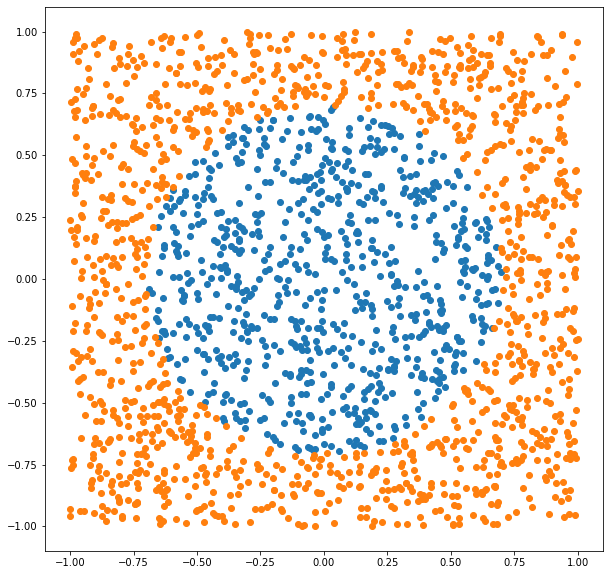

In [3]:
classifier = NSWClassifier()
data = dg.gen(N=2000, border=0.7)
classifier.build_navigable_graph(data, attempts=20)

# show classes
cls0 = np.array([r[0] for r in data if r[1] == 0])
cls1 = np.array([r[0] for r in data if r[1] == 1])
plt.figure(figsize=(10, 10))
plt.scatter(cls0[:,0], cls0[:,1])
plt.scatter(cls1[:,0], cls1[:,1])
plt.show()

iteration 0
path 190, time 1.161
1-nn 196, time 1.307
5-nn 192, time 1.451
iteration 1
path 382, time 1.518
1-nn 392, time 1.456
5-nn 386, time 1.220
iteration 2
path 568, time 1.159
1-nn 588, time 1.453
5-nn 579, time 1.673
iteration 3
path 760, time 1.112
1-nn 784, time 1.572
5-nn 771, time 1.259
iteration 4
path 950, time 0.951
1-nn 980, time 1.243
5-nn 964, time 1.131
iteration 5
path 1140, time 0.878
1-nn 1176, time 1.352
5-nn 1158, time 1.164
iteration 6
path 1327, time 0.866
1-nn 1372, time 1.323
5-nn 1350, time 1.173
iteration 7
path 1517, time 1.056
1-nn 1568, time 1.267
5-nn 1542, time 1.215
iteration 8
path 1713, time 1.279
1-nn 1764, time 2.013
5-nn 1736, time 1.354
iteration 9
path 1899, time 1.357
1-nn 1960, time 1.425
5-nn 1928, time 1.192
iteration 10
path 2086, time 0.983
1-nn 2156, time 1.297
5-nn 2121, time 1.351
iteration 11
path 2275, time 0.992
1-nn 2352, time 1.287
5-nn 2313, time 1.112
iteration 12
path 2464, time 1.309
1-nn 2548, time 1.394
5-nn 2506, time 1.09

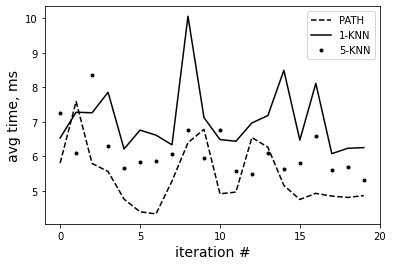

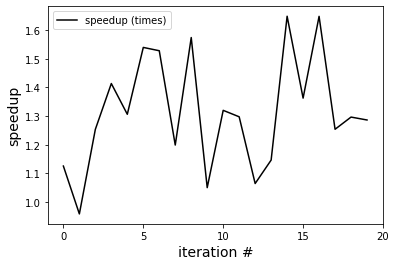

Speedup: Min = 0.96, Max = 1.65, Avg = 1.31


In [4]:
test = dg.gen(N=200, border=0.7)
analyze_classifier(classifier, test, "Synth", iterations=20)

In [5]:
classifier = NSWClassifier()
data = dg.gen(N=5000, border=0.7)
classifier.build_navigable_graph(data, attempts=10)
test = dg.gen(N=400, border=0.7)

Classifier graph is build in 42.064s


iteration 0
path 388, time 2.812
1-nn 394, time 3.666
5-nn 393, time 3.639
iteration 1
path 779, time 2.687
1-nn 788, time 3.375
5-nn 786, time 2.990
iteration 2
path 1169, time 2.326
1-nn 1182, time 3.513
5-nn 1179, time 3.405
iteration 3
path 1558, time 2.383
1-nn 1576, time 3.072
5-nn 1572, time 3.249
iteration 4
path 1941, time 2.627
1-nn 1970, time 3.766
5-nn 1965, time 3.220
iteration 5
path 2331, time 2.379
1-nn 2364, time 3.342
5-nn 2358, time 3.136
iteration 6
path 2717, time 2.743
1-nn 2758, time 3.688
5-nn 2752, time 3.313
iteration 7
path 3110, time 2.438
1-nn 3152, time 3.273
5-nn 3146, time 5.515
iteration 8
path 3497, time 2.521
1-nn 3546, time 3.565
5-nn 3539, time 3.171
iteration 9
path 3885, time 2.390
1-nn 3940, time 3.894
5-nn 3933, time 3.744
iteration 10
path 4273, time 2.237
1-nn 4334, time 4.461
5-nn 4326, time 4.661
iteration 11
path 4662, time 3.698
1-nn 4728, time 4.662
5-nn 4720, time 3.541
iteration 12
path 5056, time 2.752
1-nn 5122, time 3.548
5-nn 5113, 

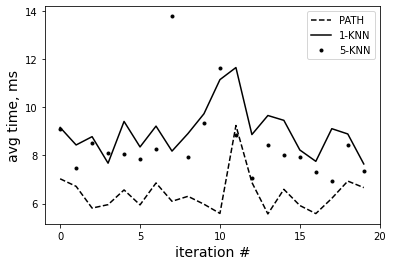

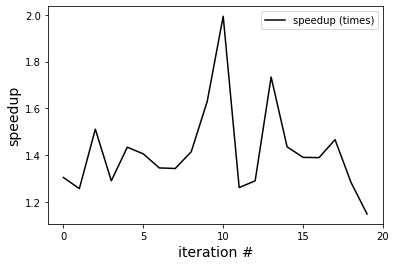

Speedup: Min = 1.15, Max = 1.99, Avg = 1.42


In [6]:
analyze_classifier(classifier, test, "Synth", iterations=20)

!! NB: speedup does not depend on dataset size

Classifier graph is build in 28.525s
Analyzing 4 case
iteration 0
path 184, time 1.201
1-nn 182, time 1.572
5-nn 183, time 1.437
iteration 1
path 370, time 1.044
1-nn 364, time 1.714
5-nn 366, time 1.393
iteration 2
path 556, time 1.172
1-nn 546, time 1.603
5-nn 549, time 1.863
iteration 3
path 741, time 1.065
1-nn 728, time 1.766
5-nn 732, time 1.358
iteration 4
path 927, time 1.053
1-nn 910, time 1.776
5-nn 915, time 1.708
iteration 5
path 1112, time 1.001
1-nn 1092, time 1.600
5-nn 1099, time 1.358
iteration 6
path 1297, time 0.927
1-nn 1274, time 2.149
5-nn 1282, time 1.574
iteration 7
path 1481, time 1.593
1-nn 1456, time 2.233
5-nn 1465, time 2.245
iteration 8
path 1667, time 1.369
1-nn 1638, time 1.909
5-nn 1649, time 1.451
iteration 9
path 1853, time 1.029
1-nn 1820, time 1.985
5-nn 1833, time 1.942
Synth: PATH classifier accuracy = 92.65%
Synth: 1-NN classifier accuracy = 91.00%
Synth: 5-NN classifier accuracy = 91.65%


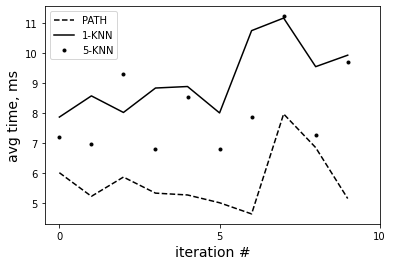

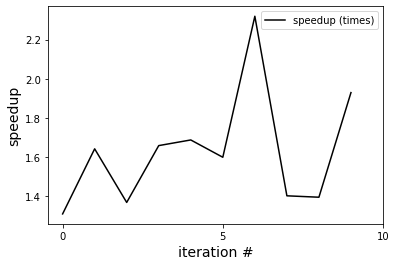

Speedup: Min = 1.31, Max = 2.32, Avg = 1.63
Classifier graph is build in 186.965s
Analyzing 16 case
iteration 0
path 106, time 3.481
1-nn 104, time 9.928
5-nn 107, time 6.293
iteration 1
path 219, time 3.550
1-nn 208, time 9.698
5-nn 213, time 6.482
iteration 2
path 328, time 3.446
1-nn 312, time 10.037
5-nn 320, time 6.379
iteration 3
path 438, time 3.444
1-nn 416, time 9.199
5-nn 426, time 6.201
iteration 4
path 544, time 3.395
1-nn 520, time 9.500
5-nn 533, time 6.957
iteration 5
path 653, time 3.574
1-nn 624, time 9.447
5-nn 639, time 7.372
iteration 6
path 764, time 2.779
1-nn 728, time 9.303
5-nn 746, time 6.692
iteration 7
path 869, time 3.384
1-nn 832, time 8.001
5-nn 852, time 6.407
iteration 8
path 977, time 2.767
1-nn 936, time 8.676
5-nn 959, time 6.420
iteration 9
path 1083, time 2.880
1-nn 1040, time 9.008
5-nn 1065, time 6.515
Synth: PATH classifier accuracy = 54.15%
Synth: 1-NN classifier accuracy = 52.00%
Synth: 5-NN classifier accuracy = 53.25%


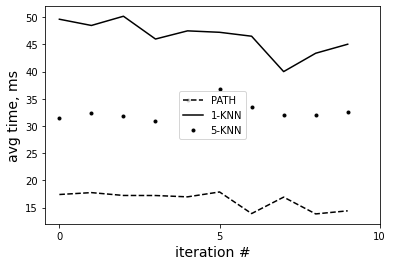

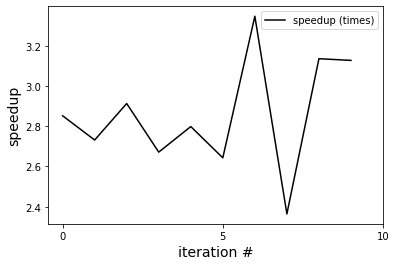

Speedup: Min = 2.36, Max = 3.35, Avg = 2.86
Classifier graph is build in 411.229s
Analyzing 64 case
iteration 0
path 85, time 9.087
1-nn 80, time 23.749
5-nn 76, time 18.289
iteration 1
path 176, time 8.880
1-nn 160, time 23.899
5-nn 150, time 20.363
iteration 2
path 261, time 8.613
1-nn 240, time 24.813
5-nn 223, time 18.911
iteration 3
path 345, time 11.126
1-nn 320, time 24.578
5-nn 296, time 19.187
iteration 4
path 432, time 9.780
1-nn 400, time 23.995
5-nn 369, time 19.540
iteration 5
path 522, time 8.379
1-nn 480, time 24.043
5-nn 443, time 18.138
iteration 6
path 613, time 9.873
1-nn 560, time 25.113
5-nn 517, time 18.270
iteration 7
path 703, time 8.956
1-nn 640, time 25.249
5-nn 590, time 17.851
iteration 8
path 790, time 8.872
1-nn 720, time 24.705
5-nn 663, time 18.283
iteration 9
path 874, time 8.334
1-nn 800, time 27.733
5-nn 736, time 19.445
Synth: PATH classifier accuracy = 43.70%
Synth: 1-NN classifier accuracy = 40.00%
Synth: 5-NN classifier accuracy = 36.80%


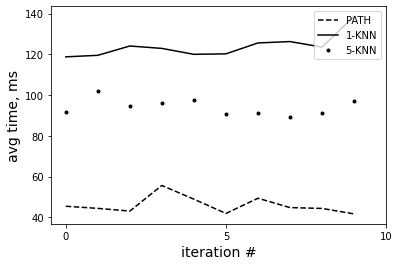

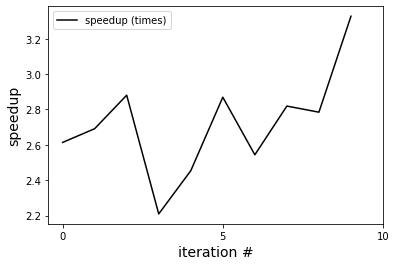

Speedup: Min = 2.21, Max = 3.33, Avg = 2.72
Classifier graph is build in 918.534s
Analyzing 256 case
iteration 0
path 91, time 24.622
1-nn 126, time 34.673
5-nn 99, time 31.199
iteration 1
path 182, time 26.023
1-nn 252, time 34.754
5-nn 197, time 31.176
iteration 2
path 267, time 25.832
1-nn 378, time 33.468
5-nn 295, time 30.176
iteration 3
path 356, time 24.188
1-nn 504, time 32.828
5-nn 393, time 32.740
iteration 4
path 443, time 26.100
1-nn 630, time 34.288
5-nn 491, time 30.624
iteration 5
path 532, time 21.381
1-nn 756, time 29.104
5-nn 589, time 28.294
iteration 6
path 621, time 23.685
1-nn 882, time 31.371
5-nn 688, time 30.238
iteration 7
path 707, time 24.385
1-nn 1008, time 32.192
5-nn 786, time 34.844
iteration 8
path 793, time 24.520
1-nn 1134, time 33.383
5-nn 885, time 31.579
iteration 9
path 880, time 23.694
1-nn 1260, time 31.464
5-nn 984, time 32.630
Synth: PATH classifier accuracy = 44.00%
Synth: 1-NN classifier accuracy = 63.00%
Synth: 5-NN classifier accuracy = 49

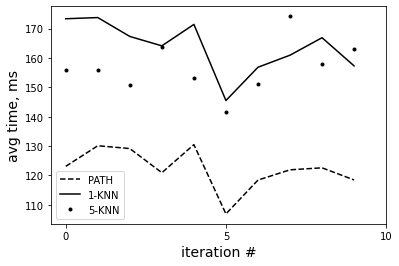

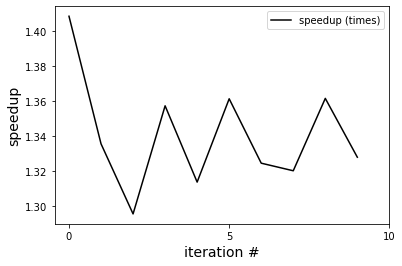

Speedup: Min = 1.30, Max = 1.41, Avg = 1.34


In [7]:
for dim in [4, 16, 64, 256]:
    classifier = NSWClassifier()
    data = dg.gen_kd(N=3000, k=dim, border=0.79 * (dim / 2) ** .5)
    classifier.build_navigable_graph(data, attempts=10)
    test = dg.gen_kd(N=200, k=dim, border=0.79 * (dim / 2) ** .5)
    print(f"Analyzing {dim} case")
    analyze_classifier(classifier, test, "Synth", iterations=10)

# 2. Simple case: MINST

```
@ARTICLE{155943,
  author={L. {Xu} and A. {Krzyzak} and C. Y. {Suen}},
  journal={IEEE Transactions on Systems, Man, and Cybernetics}, 
  title={Methods of combining multiple classifiers and their applications to handwriting recognition}, 
  year={1992},
  volume={22},
  number={3},
  pages={418-435},}
```

In [8]:
from sklearn import datasets
import random

digits = datasets.load_digits()
X, Y = [x.flatten() for x in digits.images], digits.target
XY = list(zip(X, Y))
random.shuffle(XY)
train_mnist, test_mnist = XY[:9 * len(XY) // 10], XY[9 * len(XY) // 10:]

minst_classifier = NSWClassifier()
minst_classifier.build_navigable_graph(train_mnist, attempts=20)

Classifier graph is build in 106.685s


iteration 0
path 179, time 6.243
1-nn 178, time 9.102
5-nn 178, time 8.799
iteration 1
path 358, time 6.547
1-nn 356, time 8.511
5-nn 356, time 7.873
iteration 2
path 537, time 5.923
1-nn 534, time 7.863
5-nn 534, time 8.050
iteration 3
path 716, time 6.392
1-nn 712, time 9.116
5-nn 712, time 7.633
iteration 4
path 895, time 7.146
1-nn 890, time 9.413
5-nn 890, time 8.444
iteration 5
path 1074, time 6.153
1-nn 1068, time 8.423
5-nn 1068, time 8.001
iteration 6
path 1253, time 6.381
1-nn 1246, time 8.449
5-nn 1246, time 7.789
iteration 7
path 1432, time 5.908
1-nn 1424, time 8.750
5-nn 1424, time 7.512
iteration 8
path 1611, time 6.292
1-nn 1602, time 8.732
5-nn 1602, time 7.861
iteration 9
path 1790, time 6.088
1-nn 1780, time 9.202
5-nn 1780, time 7.598
MNIST: PATH classifier accuracy = 99.44%
MNIST: 1-NN classifier accuracy = 98.89%
MNIST: 5-NN classifier accuracy = 98.89%


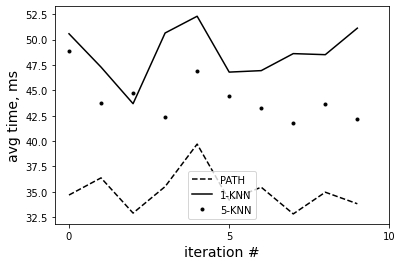

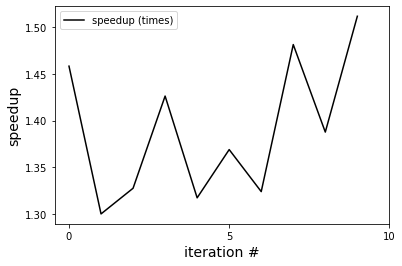

Speedup: Min = 1.30, Max = 1.51, Avg = 1.39


In [9]:
analyze_classifier(minst_classifier, test_mnist, 'MNIST', iterations=10)

# 100 leaves

[dataset](https://archive.ics.uci.edu/ml/datasets/One-hundred+plant+species+leaves+data+set)

```
@inproceedings{Mallah2013PLANTLC,
  title={PLANT LEAF CLASSIFICATION USING PROBABILISTIC INTEGRATION OF SHAPE, TEXTURE AND MARGIN FEATURES},
  author={Charles D. Mallah and James S. Cope and James Orwell},
  year={2013}
}
```

In [10]:
import random

texture_file = "../data/100leaves/data_Tex_64.txt"
shape_file = "../data/100leaves/data_Sha_64.txt"
margin_file = "../data/100leaves/data_Mar_64.txt"

dataset1, dataset2, dataset3 = [], [], []
for line1, line2, line3 in zip(open(texture_file), open(shape_file), open(margin_file)):
    parts = line1.strip().split(',')
    class_, vect = parts[0], list(map(float, parts[1:]))
    dataset1.append((vect, class_))
    
    parts = line2.strip().split(',')
    class_, vect = parts[0], list(map(float, parts[1:]))
    dataset2.append((vect, class_))
    
    parts = line3.strip().split(',')
    class_, vect = parts[0], list(map(float, parts[1:]))
    dataset3.append((vect, class_))

random.shuffle(dataset1)
random.shuffle(dataset2)
random.shuffle(dataset3)

train 1439; test 160
Classifier graph is build in 104.585s
iteration 0
path 115, time 8.674
1-nn 59, time 11.896
5-nn 93, time 9.607
iteration 1
path 230, time 8.639
1-nn 118, time 11.078
5-nn 186, time 9.818
iteration 2
path 345, time 9.272
1-nn 177, time 11.257
5-nn 279, time 9.530
iteration 3
path 460, time 8.956
1-nn 236, time 12.082
5-nn 372, time 9.854
iteration 4
path 575, time 9.253
1-nn 295, time 10.722
5-nn 465, time 10.025
iteration 5
path 690, time 9.169
1-nn 354, time 11.149
5-nn 558, time 11.359
iteration 6
path 805, time 9.529
1-nn 413, time 12.040
5-nn 651, time 9.861
iteration 7
path 920, time 10.085
1-nn 472, time 11.458
5-nn 744, time 11.940
iteration 8
path 1035, time 10.456
1-nn 531, time 14.159
5-nn 837, time 10.881
iteration 9
path 1150, time 10.105
1-nn 590, time 10.844
5-nn 930, time 9.339
100LEAVES: PATH classifier accuracy = 71.88%
100LEAVES: 1-NN classifier accuracy = 36.88%
100LEAVES: 5-NN classifier accuracy = 58.12%


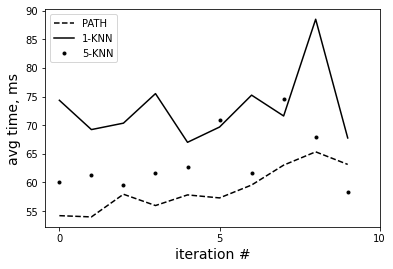

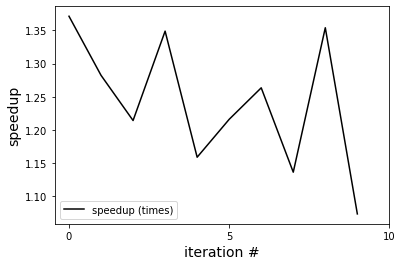

Speedup: Min = 1.07, Max = 1.37, Avg = 1.24
train 1439; test 160
Classifier graph is build in 87.416s
iteration 0
path 106, time 9.280
1-nn 53, time 9.477
5-nn 84, time 8.363
iteration 1
path 212, time 8.927
1-nn 106, time 8.916
5-nn 168, time 7.900
iteration 2
path 318, time 9.180
1-nn 159, time 9.083
5-nn 252, time 8.929
iteration 3
path 424, time 8.685
1-nn 212, time 9.289
5-nn 336, time 7.898
iteration 4
path 530, time 9.006
1-nn 265, time 11.085
5-nn 420, time 8.473
iteration 5
path 636, time 10.618
1-nn 318, time 9.123
5-nn 504, time 8.845
iteration 6
path 742, time 8.968
1-nn 371, time 9.252
5-nn 588, time 9.602
iteration 7
path 848, time 9.346
1-nn 424, time 9.369
5-nn 672, time 8.628
iteration 8
path 954, time 8.834
1-nn 477, time 9.237
5-nn 756, time 8.840
iteration 9
path 1060, time 9.464
1-nn 530, time 11.446
5-nn 840, time 9.192
100LEAVES: PATH classifier accuracy = 66.25%
100LEAVES: 1-NN classifier accuracy = 33.12%
100LEAVES: 5-NN classifier accuracy = 52.50%


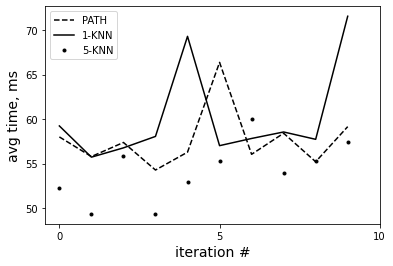

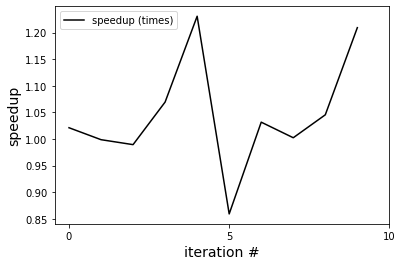

Speedup: Min = 0.86, Max = 1.23, Avg = 1.05
train 1439; test 160
Classifier graph is build in 89.592s
iteration 0
path 113, time 9.050
1-nn 81, time 9.958
5-nn 97, time 8.728
iteration 1
path 226, time 8.943
1-nn 162, time 9.781
5-nn 194, time 9.331
iteration 2
path 339, time 9.100
1-nn 243, time 10.175
5-nn 291, time 10.281
iteration 3
path 452, time 9.254
1-nn 324, time 9.948
5-nn 388, time 10.345
iteration 4
path 565, time 9.016
1-nn 405, time 11.878
5-nn 485, time 11.389
iteration 5
path 678, time 9.124
1-nn 486, time 9.941
5-nn 582, time 9.866
iteration 6
path 791, time 8.701
1-nn 567, time 9.751
5-nn 679, time 8.991
iteration 7
path 904, time 9.060
1-nn 648, time 9.877
5-nn 776, time 9.127
iteration 8
path 1017, time 8.390
1-nn 729, time 10.135
5-nn 873, time 8.893
iteration 9
path 1130, time 9.084
1-nn 810, time 10.032
5-nn 970, time 9.098
100LEAVES: PATH classifier accuracy = 70.62%
100LEAVES: 1-NN classifier accuracy = 50.62%
100LEAVES: 5-NN classifier accuracy = 60.62%


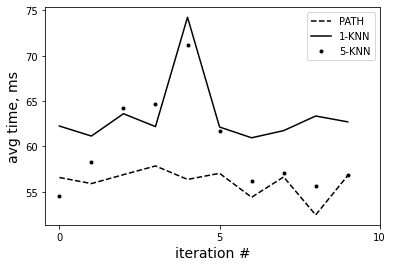

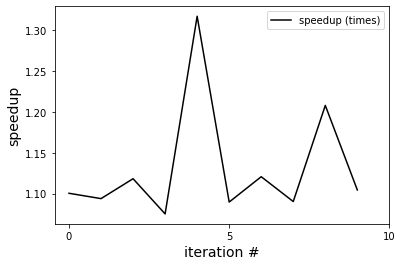

Speedup: Min = 1.08, Max = 1.32, Avg = 1.13


In [11]:
for dataset in [dataset1, dataset2, dataset3]:
    train_leaves, test_leaves = dataset[:9 * len(dataset) // 10], dataset[9 * len(dataset) // 10:]
    print(f"train {len(train_leaves)}; test {len(test_leaves)}")

    leaves_classifier = NSWClassifier()
    leaves_classifier.build_navigable_graph(train_leaves, attempts=10)
    analyze_classifier(leaves_classifier, test_leaves, "100LEAVES", iterations=10)

## 1024 dim data
Download `data8.pickle` from https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed

In [12]:
import pickle

with open('../data/data8.pickle', 'rb') as f:
    data = pickle.load(f)

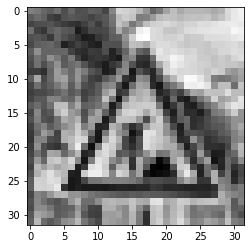

In [13]:
x_train = data['x_train']
x_train = x_train.reshape((86989, -1))
y_train = data['y_train']

x_train, y_train = x_train[:10000, :], y_train[:10000]

x_test = data['x_test']
x_test = x_test.reshape((12630, -1))
y_test = data['y_test']

x_test, y_test = x_test[:500, :], y_test[:500]

plt.imshow(x_test[0].reshape(32, 32), cmap="gray")
plt.show()

In [15]:
import cv2
dataset = list(zip(x_train, y_train))
dataset_small = []
for r in dataset:
    r2 = cv2.resize(r[0].reshape((32, 32)), (16, 16)).reshape((-1))
    dataset_small.append((r2, r[1]))

signs_classifier = NSWClassifier()
signs_classifier.build_navigable_graph(dataset_small, attempts=5)

Classifier graph is build in 8485.606s


In [16]:
testset = list(zip(x_test, y_test))[:100]
testset_small = []
for r in testset:
    r2 = cv2.resize(r[0].reshape((32, 32)), (16, 16)).reshape((-1))
    testset_small.append((r2, r[1]))

iteration 0
path 37, time 17.092
1-nn 18, time 52.022
5-nn 30, time 27.585
iteration 1
path 75, time 17.231
1-nn 36, time 30.470
5-nn 60, time 26.506
iteration 2
path 113, time 18.210
1-nn 54, time 30.491
5-nn 90, time 27.496
iteration 3
path 151, time 17.797
1-nn 72, time 30.621
5-nn 120, time 27.017
iteration 4
path 189, time 17.746
1-nn 90, time 29.854
5-nn 150, time 26.417
iteration 5
path 225, time 17.775
1-nn 108, time 29.654
5-nn 180, time 26.392
iteration 6
path 263, time 16.875
1-nn 126, time 29.404
5-nn 210, time 28.522
iteration 7
path 301, time 18.029
1-nn 144, time 30.127
5-nn 240, time 26.162
iteration 8
path 338, time 20.372
1-nn 162, time 31.900
5-nn 270, time 25.756
iteration 9
path 375, time 16.741
1-nn 180, time 30.454
5-nn 300, time 27.778
signs: PATH classifier accuracy = 37.50%
signs: 1-NN classifier accuracy = 18.00%
signs: 5-NN classifier accuracy = 30.00%


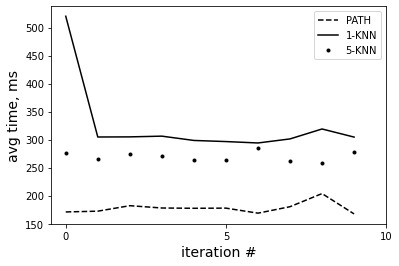

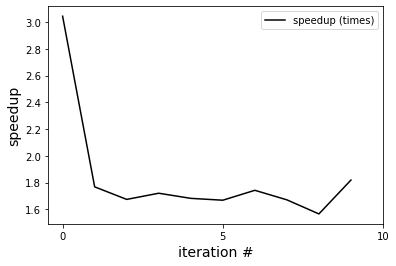

Speedup: Min = 1.57, Max = 3.04, Avg = 1.84


In [18]:
analyze_classifier(signs_classifier, testset_small, "signs", iterations=10)